In [1]:
import datetime
import importlib
import logging
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE

import config
import db
import fetcher
import model
import strategy

C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
def rolling_predictions(
    cfg: config.BaseConfig, 
    nhits: NHiTS,
    val_df: pd.DataFrame,
    train_dataset: TimeSeriesDataSet,
    group_id: str,
    context_length: int,
    prediction_length: int
) -> list:
    """
    Step through the validation set and make a prediction at each step using context_length.

    Args:
        cfg: BaseConfig.
        nhits: Trained NHiTS model.
        val_df: DataFrame with validation data.
        train_dataset: Original training TimeSeriesDataSet for metadata reuse.
        group_id: Which group to run predictions on (as string).
        context_length: Number of time steps used as model input.
        predictions_length

    Returns:
        List of (time_idx, prediction) tuples.
    """
    conn, cur = db.connect_to_db()
    cash, stocks = strategy.get_account_data(cur, cfg.account_table)
    num_buys = 0
    num_sells = 0
    closing_price = 0
    df_group = val_df[val_df["group_id"] == group_id].reset_index(drop=True)
    results = [] # tidx, predicted value at tidx + 1, currentPrice at tidx - predicted value at tidx + 1, accountValue after trade, action from trade

    max_idx = len(df_group) - context_length + 1

    for i in range(max_idx):
        context_df = df_group.iloc[i : i + context_length].copy()
        pred_value = model.make_prediction(nhits, context_df, train_dataset, prediction_length)
        prediction_time_idx = context_df.iloc[-1]["time_idx"]
        closing_price= context_df.iloc[-1]["currentPrice"]
        cash, stocks, action = strategy.trade(closing_price, pred_value, cash, stocks)
        if action == "bought":
            num_buys += 1
        else:
            num_sells += 1
        accountValue = cash + stocks*closing_price
        results.append((prediction_time_idx, pred_value, closing_price - pred_value, accountValue, action))

    return results

In [4]:
def analyze(results, val_df)->float:
    # Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=["time_idx", "predicted", "vsCurrent", "accountValue", "action"])
    results_df["time_idx"] = results_df["time_idx"].astype(int)

    # Shift prediction time to match the actual it is predicting
    results_df["predicted_time_idx"] = results_df["time_idx"] + 1

    # Filter val_df for the correct group
    val_group = val_df[val_df["group_id"] == "0"].copy()
    val_group = val_group.drop_duplicates(subset=["time_idx"])

    # Merge using shifted time index
    comparison_df = pd.merge(
        results_df,
        val_group[["time_idx", "currentPrice"]],
        left_on="predicted_time_idx",
        right_on="time_idx",
        how="left",
        suffixes=("_pred", "_actual")
    )

    # Optional comparison
    comparison_df["error"] = comparison_df["predicted"] - comparison_df["currentPrice"]
    comparison_df["above_actual"] = comparison_df["error"] > 0
    comparison_df["below_input"]=comparison_df["vsCurrent"] > 0

    # Compute comparison
    comparison_df["vsNextCurrentPrice"] = comparison_df["error"].apply(
        lambda x: "above" if x > 0 else ("below" if x < 0 else "equal")
    )
    comparison_df["vsCurrentPrice"] = comparison_df["vsCurrent"].apply(
        lambda x: "below" if x > 0 else ("above" if x < 0 else "equal")
    )

    # Get percentage breakdown
    percentages = comparison_df["vsNextCurrentPrice"].value_counts(normalize=True) * 100
    percentages_curr = comparison_df["vsCurrentPrice"].value_counts(normalize=True) * 100
    percentages_bought_sold = comparison_df["action"].value_counts(normalize=True) * 100

    offset = results_df["vsCurrent"].mean()

    print(percentages)
    print(percentages_curr)
    print(percentages_bought_sold)
    print(offset)
    return offset

In [5]:
def plot_all_groups(data: pd.DataFrame, time_col="time_idx", value_col="currentPrice", group_col="group_id"):
    plt.figure(figsize=(14, 6))
    for group_id, group_df in data.groupby(group_col):
        plt.plot(group_df[time_col], group_df[value_col], label=f'Group {group_id}')
    
    plt.title("Time Series per Group")
    plt.xlabel("Time Index")
    plt.ylabel(value_col)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_predictions_over_time(predictions, value_col="currentPrice"):
    # Extract needed data
    df_idx = predictions.index
    true = predictions.y[0].view_as(predictions.output.prediction)
    pred = predictions.output.prediction  # predicted values
    grouped = df_idx.groupby("group_id")
    plt.figure(figsize=(28, 6))

    for group_id, group_idx in grouped:
        print(group_id)
        print(group_idx.head(5))
        print(group_idx.tail(5))
        time_base = group_idx["time_idx"].values

        # Plot actual full true sequence (first step from each decoder target)
        plt.plot(time_base, true[:, 0][group_idx.index], label=f"True Group {group_id}")

        # Plot first prediction step
        plt.plot(time_base, pred[:, 0][group_idx.index], linestyle="--", label=f"Pred Group {group_id}")

    plt.title("First Step-Ahead Predictions vs True Values")
    plt.xlabel("Time Index")
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [2]:
importlib.reload(model)
importlib.reload(fetcher)
importlib.reload(config)
importlib.reload(db)
importlib.reload(strategy)
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", ".*does not have many workers.*")
test_config=config.get_test_config()
prod_config=config.get_prod_config()

In [3]:
conn, cur = db.connect_to_db()
cc=np.float64(2330.34)
strategy.write_account_data(conn, cur, cc, 0, np.float64(233.34), cc, 0, 0, test_config.account_table)

[datetime.datetime(2025, 5, 15, 16, 35, 31, 641789, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>), 2330.34, 0, 233.34, 2330.34, 0, 0]


In [4]:
db.disconnect_from_db(conn, cur)

In [8]:
sys.stderr.write(f"Starting model training at: {datetime.datetime.now(test_config.eastern)}\n")
best_model_path, train_dataset, val_df=model.train_best_model(test_config)
print(best_model_path)
sys.stderr.write(f"Completed model training at: {datetime.datetime.now(test_config.eastern)}\n")

Starting model training at: 2025-05-14 11:17:24.124665-04:00
Seed set to 42
C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


NameError: name 'exit' is not defined

In [102]:
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [126]:
results = rolling_predictions(test_config, best_model, val_df, train_dataset, "1", test_config.context_length, test_config.prediction_length)

6307


In [129]:
results = model.rolling_predictions(best_model, val_df, train_dataset, "1", test_config.context_length, test_config.prediction_length)

In [135]:
offset = model.analyze(results, val_df)

vsNextCurrentPrice
above    76.15348
below    23.84652
Name: proportion, dtype: float64
vsCurrentPrice
above    100.0
Name: proportion, dtype: float64
-7.770935706985712e-05


In [105]:
conn, cur = db.connect_to_db()
raw_data = db.fetch_data(cur, test_config.quote_table)
processed_data=model.add_tidx_and_groupid(raw_data)
train_df, val_df = model.construct_dataframes(processed_data)
tvur, sr = model.split_columns_by_group_variation(processed_data)
train_dataset, val_dataset=model.construct_datasets(train_df, val_df, tvur, sr, test_config.context_length, test_config.prediction_length)
train_dataloader, val_dataloader = model.construct_dataloaders(train_dataset, val_dataset, batch_size=64)

Seed set to 42


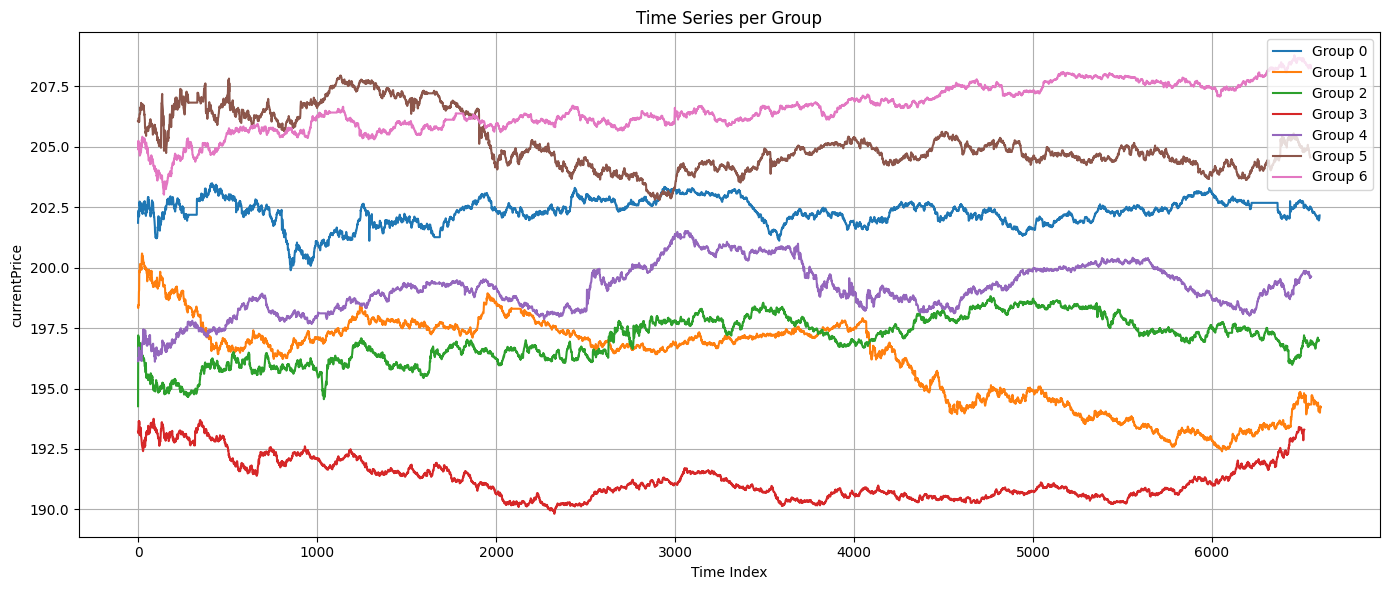

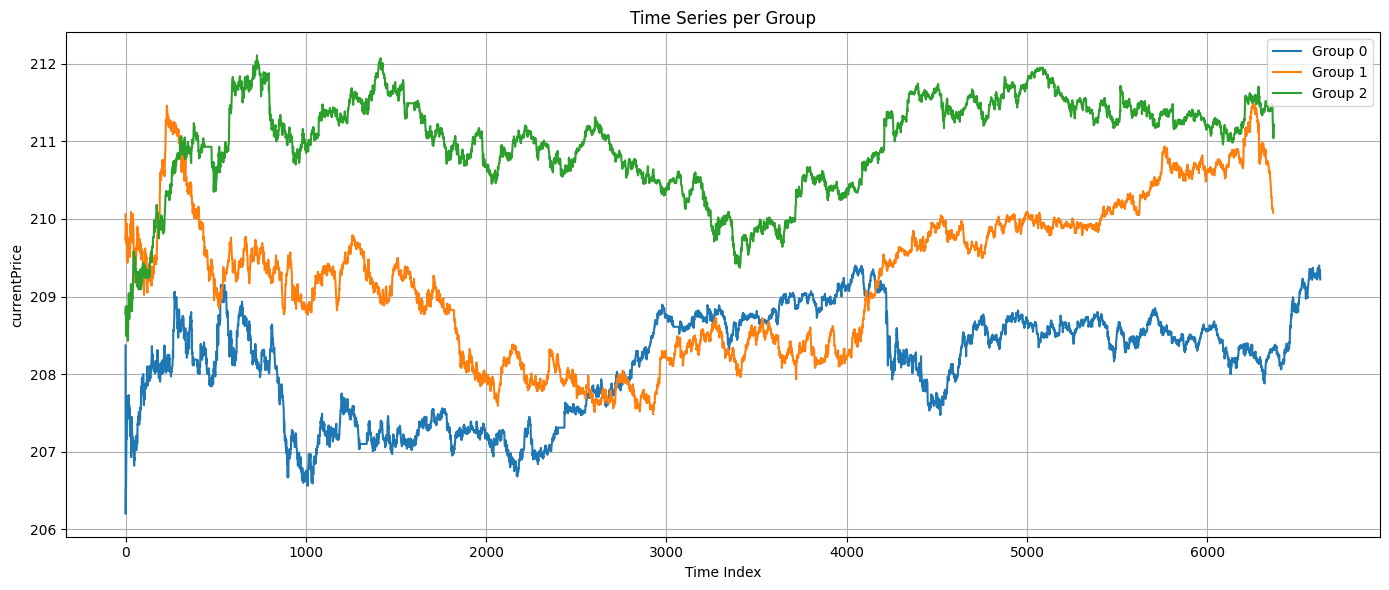

C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
C:\Users\Ryan Tay\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


tensor(0.0003)
tensor(0.0003)


In [106]:
plot_all_groups(train_df)
plot_all_groups(val_df)
val_dataloader_pred = val_dataset.to_dataloader(train=False, batch_size=1, num_workers=8)
baseline_predictions = Baseline().predict(val_dataloader_pred, trainer_kwargs={"accelerator": "cpu", "logger": False, "enable_checkpointing":False, "enable_model_summary":False, "enable_progress_bar":False}, return_y=True)
y_true = baseline_predictions.y[0].view_as(baseline_predictions.output)
print(SMAPE()(baseline_predictions.output, y_true))
predictions= best_model.predict(val_dataloader_pred, mode="raw", return_x=True, return_index=True, return_y=True, return_decoder_lengths=True, trainer_kwargs={"accelerator": "cpu", "logger": False, "enable_checkpointing":False, "enable_model_summary":False, "enable_progress_bar":False})
predictions_y_true = predictions.y[0].view_as(predictions.output.prediction)
print(SMAPE()(predictions.output.prediction.squeeze(-1), predictions_y_true.squeeze(-1)))

In [107]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs={"accelerator": "cpu", "logger": False, "enable_checkpointing":False, "enable_model_summary":False, "enable_progress_bar":False})

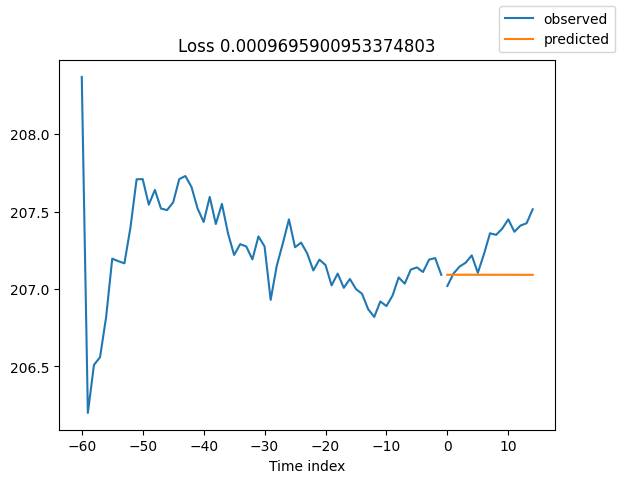

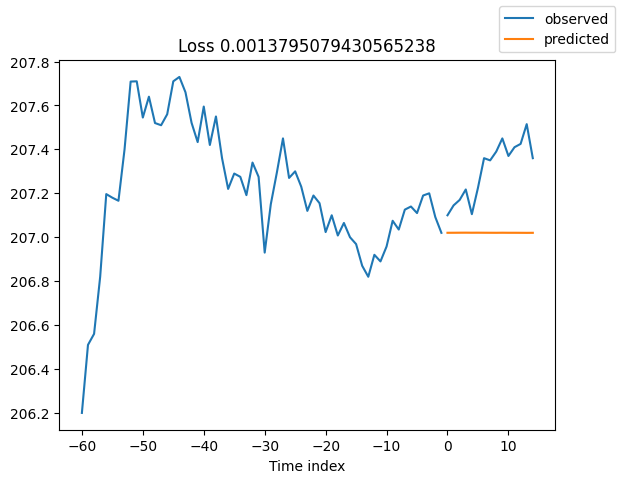

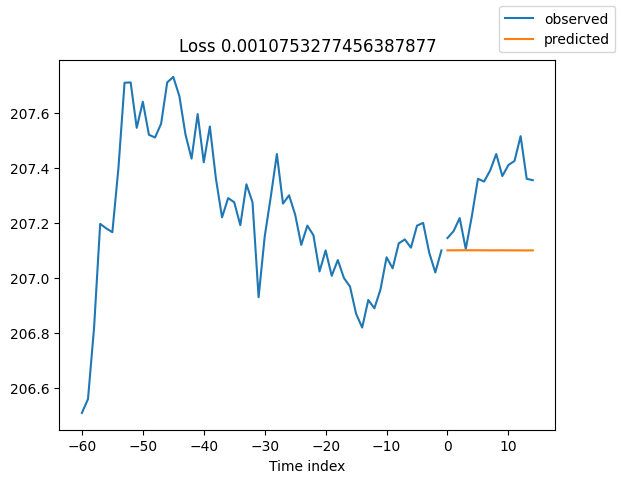

In [108]:
for idx in range(3):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)